In [153]:
from shapely.geometry import Polygon,Point
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from geometry import Circle,Rectangle,Domain2D
import numpy as np

# Geometry Tutorial

torch_DE uses shapely package to define very simple 2D geometry. As such many of the functions outlined in this tutorial are 100% compatible with any Polygon object from shapely

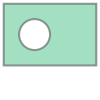

In [7]:
num_points = 1024
base = Rectangle([(1,0),(6,4)],'midpoint')
disc = Circle((0,0),r =1,num_points = num_points)

d = Domain2D(base = base)
d.remove(disc,names = ['hole'])
d.create_boundary_group('hole','wall-1')
d.Domain


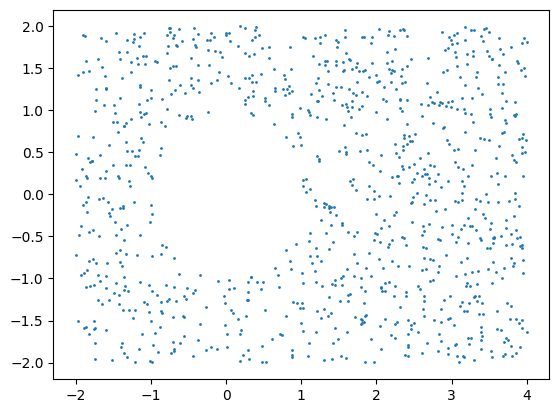

In [23]:
sampled_points = d.generate_points(1000)

plt.scatter(sampled_points[:,0],sampled_points[:,1],s=1)

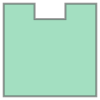

In [10]:
a = Rectangle(((0,0),(3,3)),'midpoint')
b = Rectangle(((0,1.5),(1,1)),'midpoint')

c = Domain2D(base = a)
c.remove(b,names = ['hole'])
c.Domain

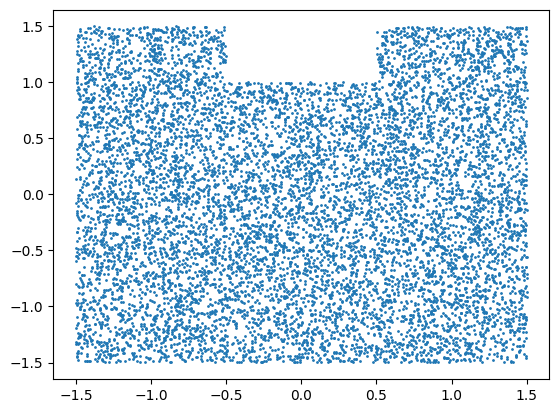

In [11]:
sampled_points = c.generate_points(10000)

plt.scatter(sampled_points[:,0],sampled_points[:,1],s=1)
# triangulate_shape(d.Domain,show_plot=True)

# Navier Stokes


In [181]:
import torch
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from continuous.DE_module import DE_Getter
from continuous.Networks import *

import pytorch_lightning as pl

In [182]:
class CombinedDataloader():
    def __init__(self, *dataloaders,group_names = None):
        self.dataloaders = dataloaders
        self.group_names = group_names
    def __iter__(self):
        for data in zip(*self.dataloaders):
            yield data
            
def combined_dataloader(datasets,num_iters,group_names = None,**kwargs):
    '''
    Given a list of datasets create an iterater that functions as a combined dataloader. The dataloader is such that the number of iteration i.e. length of each
    individual dataloader is the same.
    
    datasets
    **kwargs any keyword arguements to pass to dataloaders. The keyword is applied to all dataloaders

    '''
    DLs = []
    for dataset in datasets:
        bs = len(dataset)//num_iters
        DL = DataLoader(dataset,batch_size=bs,**kwargs)
        DLs.append(DL)
    return CombinedDataloader(*DLs)

In [183]:
class loss_func():
    def __init__(self,func,name,groupID = 'all',variable :str = None,target = 0) -> None:
        self.func = func
        self.name = name
        self.variable = variable
        self.groupID = groupID if isinstance(groupID,str) else 'all'
        self.target = 0
        
    def __call__(self,out,target_input = None):
        if callable(self.target):
            x = self.target(target_input)
        else:
            x = self.target

        if self.variable is None:
            return self.func(out[self.groupID],x)
        else:
            return self.func(out[self.groupID][self.variable],x)


In [187]:
class PINN_Model(pl.LightningModule):
    def __init__(self, net : nn.Module,group_names = None,to_logger:bool = False,log_each_term:bool = True) -> None:
        super().__init__()
        self.net = net
        self.optimiser = torch.optim.Adam(net.parameters(),lr = 1e-3)
        self.lr_scheduler = None
        self.PINN = DE_Getter(net = self.net)
        self.group_names = group_names
        self.loss_terms = {}
        #Lighning Stuff
        self.to_log = to_logger
        self.log_each_term = log_each_term
    
    @property
    def input_vars(self):
        return self.PINN.input_vars

    @property 
    def input_vars_idx(self):
        return self.PINN.input_vars_idx


    def add_loss_term(self,func,groupID=None,variable = None,target = 0,name: str = None):
        '''
        Add loss term to PINN model.

        Arguments:
        func : callable loss function that takes in two variables: prediction by the Network and the target value to be compared with. An example
            of a func is the mean square error function expressed as MSE(x,y) = lambda x,y: (x-y).pow(2).mean()


        groupID str : Default 'all' : string key indicating the specific group to perform the loss function, func, over. set to None or 'all' will perform the loss
            over the entire output batch

        variable: str  | None:  Default: None. String indicating which specific output to pass into func. Leave as None to pass the entire 
            output dict into func.
        
        target: float | torch.tensor | func : target value(s) to compare the output of the Network if target is a float or tensor. target is a function,
            then it takes into 
        
        name: str | None : Default: None. String to name loss term. if None then will assign the name Loss_term_{len(self.loss)}
        '''
        if name is None:
            name = f'Loss_Eq_{len(self.loss_terms.keys())}'

        assert name not in self.loss_terms.keys(), f'The name {name} already exists, Please rename this or the existing loss term'
        
        self.loss_terms[name] = loss_func(func,name,groupID,variable = variable,target = target)

    def set_optimizer(self,optimiser:torch.optim.Optimizer,**kwargs):
        self.optimiser = optimiser(self.net.parameters(),**kwargs)

    def set_lr_scheduler(self,scheduler,**kwargs):
        self.lr_scheduler = scheduler(self.optimiser,**kwargs)
    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer
        else:
            return [self.optimizer],[self.lr_scheduler]
    def group_training_data(self,train_batch,group_names):
        data_dic = {group_name : data for group_name,data in zip(group_names,train_batch)}
        data_dic['all'] = torch.cat(train_batch,dim = 0)
        
        output_dic = {}
        for name,train_input in data_dic.items():
            output_dic[name] = {}
            for var_name in self.PINN.input_vars:
                 

        return data_dic
    def on_train_start(self) -> None:
        '''
        Create the initial dictionaries for training inputs
        '''
        self.training_input_dic = {}
        for name in ['all'] + self.group_names:
            self.training_input_dic[name] = {}
            for var_name in self.input_vars:
                self.training_input_dic[name][var_name] = None


    def training_step(self,train_batch, batch_idx):
        group_sizes = [data.shape[0] for data in train_batch]
        
        train_data_dic = self.group_training_data(train_batch,self.group_names)
        
        x = train_data_dic['all']
    
        
        out = self.PINN.calculate(x,self.group_names,group_sizes)

        losses = [l.compute_loss(out,data_dic[l.groupID]) for l in self.loss_terms.values()]

        
        if self.log_each_term:
            for name,loss in zip(self.loss_terms.keys(),losses):
                self.log(name,loss,total_loss,logger = self.to_log, prog_bar=False, on_step=False, on_epoch=True,reduce_fx=torch.sum)

        total_loss = torch.sum(losses)
        self.log("train_loss", total_loss,logger = self.to_log, prog_bar=True, on_step=False, on_epoch=True,reduce_fx=torch.sum)
        
        return total_loss

IndentationError: expected an indented block (855274726.py, line 65)

## Lid Driven Cavity

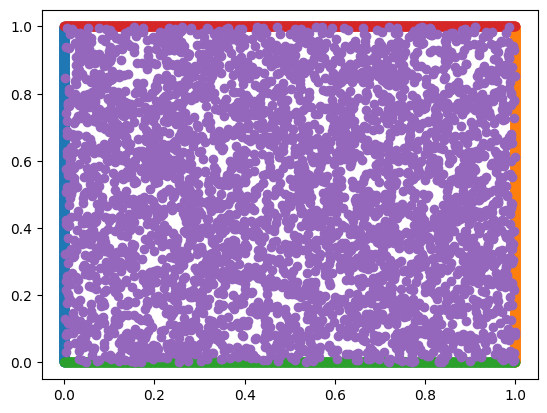

In [159]:
Re = 10

base = Rectangle([(0,0),(1,1)])

edges = base.exterior.coords

wall_points = 1000
left_wall,right_wall = [(torch.ones(wall_points)*n,torch.linspace(0,1,wall_points)) for n in [0,1] ]
bot_wall,top_wall = [(torch.linspace(0,1,wall_points),torch.ones(wall_points)*n) for n in [0,1] ]

domain = Domain2D(base)
points = domain.generate_points(4000)


for wall in [left_wall,right_wall,bot_wall  ,top_wall]:
    plt.scatter(*wall)

plt.scatter(points[:,0],points[:,1])


In [161]:
def steady_navierStokes2D(out,Re):
    #Really shouldnt do this buy lasy af
    return (out['u_x']*out['u']+ out['u_y']*out['v'] +out['p_x'] - 1/Re*(out['u_xx']+out['u_yy']),
            out['v_x']*out['u']+ out['v_y']*out['v'] +out['p_y'] - 1/Re*(out['v_xx']+out['v_yy']) )


def incompressibility(out):
    return out['u_x']+out['v_y']
Re = 10

## Kovasznay_flow

In [185]:
Re = 50
U = 1
lamb = float(1/2*(Re - np.sqrt(Re**2+16*np.pi**2)))
analytic_u = lambda x,y: U*(1-torch.exp(lamb*x)*torch.cos(2*torch.pi*y) )
analytic_v = lambda x,y: -U*(lamb/(2*torch.pi)*torch.exp(lamb*x)*torch.sin(2*torch.pi*y))

def analytic_u(training_)


In [186]:
def MSE(pred,target):
    return (pred-target).pow(2).mean()

In [180]:
net = Networks.Modified_Fourier_Net(2,3,50,5,50,activation='sin',adaptive_activation= True)
Kov_flow = PINN_Model(net=net)
PINN = Kov_flow.PINN
PINN.set_vars(input_vars= ['x','y'], output_vars= ['u','v','p'])

derivs = ['u_x','u_y','u_xx','u_yy',
          'v_x','v_y','v_xx','v_yy',
          'p_x','p_y'
          ]

PINN.set_derivatives(derivatives=derivs)
Kov_flow.group_names = ['inlet','top','bot','collocation']

Kov_flow.add_loss_term(func = MSE,groupID= 'inlet',variable = 'u', target = analytic_u,name = 'inlet_condition' )
Kov_flow.add_loss_term(func = MSE,groupID= 'inlet',variable = 'u', target = analytic_u,name = 'inlet_condition' )
Kov_flow.add_loss_term(func = MSE,groupID= 'inlet',variable = 'u', target = analytic_u,name = 'inlet_condition' )
Kov_flow.add_loss_term(func = MSE,groupID= 'inlet',variable = 'u', target = analytic_u,name = 'inlet_condition' )

In [169]:
inlet = torch.stack(left_wall,dim = -1)
outlet = torch.stack(right_wall,dim = -1)
top ,bot = [torch.stack(wall,dim=-1) for wall in [top_wall,bot_wall]]
Collocation = domain.generate_points(6000,output_type='torch')
data = combined_dataloader([inlet,top,bot,Collocation],num_iters= 1)



In [ ]:
net = Networks.Modified_Fourier_Net(2,3,50,5,50,activation='sin',adaptive_activation= True)
model = Kovasznay_flow(net=net,L = 0.5)

PINN = model.PINN
PINN.set_vars(input_vars= ['x','y'], output_vars= ['u','v','p'])

derivs = ['u_x','u_y','u_xx','u_yy',
          'v_x','v_y','v_xx','v_yy',
          'p_x','p_y'
          ]

PINN.set_derivatives(derivatives=derivs)
model.group_names = ['inlet','top','bot','collocation']

### Data Wrangling

In [20]:
def MSE(x:torch.tensor):
    return x.pow(2).mean()

In [6]:
class Lid_Driven_Cavity(pl.LightningModule):
    def __init__(self, net : nn.Module,group_names = None) -> None:
        super().__init__()
        self.net = net
        self.PINN = DE_Getter(net = self)
        self.group_names = group_names
    
    def forward(self,x):
        return self.net(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr = 1e-4)
    
    def training_step(self, train_batch, batch_idx):
        group_sizes = [data.shape[0] for data in train_batch]
        
        x = torch.cat(train_batch,dim = 0)
        out = self.PINN.calculate(x,self.group_names,group_sizes)

        #No Slip Walls
        l1 = MSE(out['NoSlip']['u']) + MSE(out['NoSlip']['v'])

        #Top_Wall
        #Weight it by x co ord
        x_co = train_batch[1][:,0]
        weight = 1 - 20*torch.abs(x_co)
        
        l2 = (weight*((out['Lid']['u'] - 1).pow(2))).mean()

        # NS Loss
        l3 = sum([MSE(NS) for NS in steady_navierStokes2D(out['Collocation'],Re =10) ])
        l4 = MSE(incompressibility(out['Collocation']))

        loss = l1+l2+l3+l4 + MSE((out['Lid']['v']))

        #Log Losses
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True,reduce_fx=torch.sum)
        return loss


In [28]:
x = torch.linspace(0,1,100)
x.mean()

tensor(0.5000)

In [128]:
from typing import Any, Callable, Optional, Union


from pytorch_lightning.core.optimizer import LightningOptimizer
from torch.optim.optimizer import Optimizer


class Kovasznay_flow(pl.LightningModule):
    def __init__(self, net : nn.Module,group_names = None,L = 1,Re = 50) -> None:
        super().__init__()
        self.net = net
        self.PINN = DE_Getter(net = self)
        self.group_names = group_names
        self.U = 1
        self.L = L
        self.Re = Re
        self.lamb = float(1/2*(self.Re - np.sqrt(Re**2+16*np.pi**2)))

        self.analytic_u = lambda x,y: self.U*(1-torch.exp(self.lamb*x)*torch.cos(2*torch.pi*y) )
        self.analytic_v = lambda x,y: -self.U*(self.lamb/(2*torch.pi)*torch.exp(self.lamb*x)*torch.sin(2*torch.pi*y))
    def forward(self,x):
        return self.net(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr = 1e-3)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,0.9997)
        return [optimizer],[scheduler]
    
    def training_step(self, train_batch, batch_idx):
        group_sizes = [data.shape[0] for data in train_batch]
        
        x = torch.cat(train_batch,dim = 0)
        out = self.PINN.calculate(x,self.group_names,group_sizes)

        #Symmetry
        # l5 = MSE(out['top']['u'] - out['bot']['u']) +MSE(out['top']['v'] - out['bot']['v'])
        # l5 = MSE(out['top']['u_y']) + MSE(out['top']['v_y']) + MSE(out['top']['p_y'])
        # l6 = MSE(out['bot']['u_y']) + MSE(out['bot']['v_y']) + MSE(out['bot']['p_y'])
        
        # Inlet
        x_in,y_in = train_batch[0][:,0],train_batch[0][:,1]
        l1 = out['inlet']['u'] - self.analytic_u(x_in,y_in)
        l2 = out['inlet']['v'] - self.analytic_v(x_in,y_in)
        # NS Loss
        NS_x,NS_y = steady_navierStokes2D(out['collocation'],Re = 50)
        
        l3 = MSE(NS_x) + MSE(NS_y)
        
        l4 = MSE(incompressibility(out['collocation']))

        loss = MSE(l1)+MSE(l2)+l3+l4
        
        # loss =1 
        #Log Losses
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True,reduce_fx=torch.sum)
        return loss



In [151]:
def MSE_loss(pred,target):
    return (pred-target).pow(2).mean()

### SetUp

In [136]:
net = Networks.Modified_Fourier_Net(2,3,50,5,50,activation='sin',adaptive_activation= True)
model = Kovasznay_flow(net=net,L = 0.5)

PINN = model.PINN
PINN.set_vars(input_vars= ['x','y'], output_vars= ['u','v','p'])

derivs = ['u_x','u_y','u_xx','u_yy',
          'v_x','v_y','v_xx','v_yy',
          'p_x','p_y'
          ]

PINN.set_derivatives(derivatives=derivs)
model.group_names = ['inlet','top','bot','collocation']

In [143]:
inlet = torch.stack(left_wall,dim = -1)
outlet = torch.stack(right_wall,dim = -1)
top ,bot = [torch.stack(wall,dim=-1) for wall in [top_wall,bot_wall]]
Collocation = domain.generate_points(6000,output_type='torch')
data = combined_dataloader([inlet,top,bot,Collocation],num_iters= 1)

In [61]:
# NoSlipWalls = torch.cat([torch.stack(wall,dim = -1) for wall in [left_wall,right_wall,bot_wall]]) 
# Lid = torch.stack(top_wall,dim = -1)
# Collocation = domain.generate_points(4000,output_type='torch').to(torch.float32)
# data = combined_dataloader([NoSlipWalls,Lid,Collocation],num_iters= 1,shuffle = True)

In [144]:
trainer = pl.Trainer(max_epochs=20_000)
trainer.fit(model,data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                 | Params
----------------------------------------------
0 | net  | Modified_Fourier_Net | 20.8 K
----------------------------------------------
20.8 K    Trainable params
0         Non-trainable params
20.8 K    Total params
0.083     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

C:\Users\John Su\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


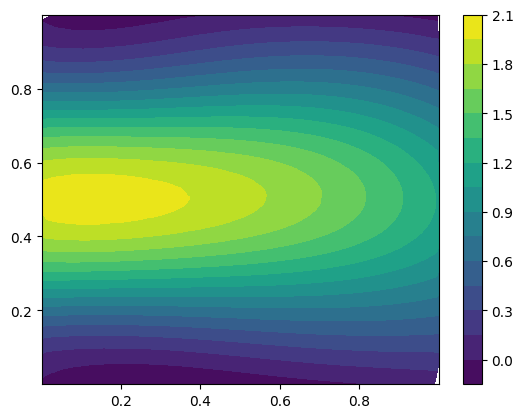

In [146]:


with torch.no_grad():
    out = net.to('cpu')(Collocation)

u = out[:,0]
v = out[:,1]

contour = plt.tricontourf(Collocation[:,0],Collocation[:,1],u,levels=20)
plt.colorbar(contour)

C:\Users\John Su\AppData\Local\Temp\ipykernel_6856\1610635393.py:7: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(contour)


-0.7774788837922912

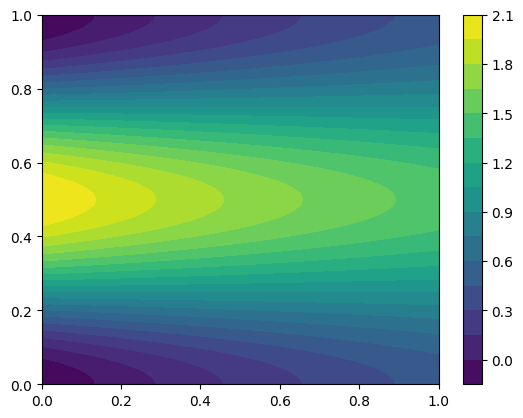

In [147]:
x,y = torch.meshgrid([torch.linspace(0,1,100),torch.linspace(0,1,100)])
x,y = x.flatten(),y.flatten()
u = model.analytic_u(x,y)
v = model.analytic_v(x,y)
# model.lamb = 16
c=plt.tricontourf(x,y,u,levels = 20)
plt.colorbar(contour)

model.lamb